In [1]:
import sys
sys.path.append("../../..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.util.setup import get_config, create_setting
from src.strategy import Strategy

In [2]:
def get_setting(setting, experiment, learn_alg, run=0):
    """ Get Strategy and Mechanism for specified experiment
    """
    num_runs = 10
    cfg, cfg_learner = get_config("experiment/soda_util/configs", setting, experiment, learn_alg)
    mechanism, game = create_setting(setting, cfg)
    name = (
                learn_alg + "_" + experiment + ("_run_" + str(run) if num_runs > 1 else "")
            )
    strategies = {}
    for i in game.set_bidder:
        strategies[i] = Strategy(i, game)
        strategies[i].load(name, setting, f"experiment/soda_util/")
    
    return mechanism, strategies, game


def get_bids(mechanism, strategies: dict, agent: str, number_o: int):
    """ Sample observation according to prior defined in mechanism and sample corresponding bids from computed strategy

    Args:
        mechanism: underlying mechanism
        strategies (dict): dict with strategies for all agents
        agent (str): agent/bidder
        n_o (int): number of observations/bids

    Returns:
        _type_: _description_
    """
    idx_agent = mechanism.bidder.index(agent)
    obs = mechanism.draw_values(number_o)[idx_agent]
    bids = strategies[agent].bid(obs)
    return obs, bids

def get_bne(mechanism, agent: str):
    """ Get BNE for given mechanism and agent

    Args:
        mechanism (_type_): _description_
        strategies (_type_): _description_
        agent (_type_): _description_

    Returns:
        _type_: _description_
    """
    lb, ub = mechanism.o_space[agent]
    x = np.linspace(lb+1e-5, ub-1e-5, 100)
    bne = mechanism.get_bne(agent, x)
    return x, bne


In [3]:
# parameter
param = {
        "fontsize_title": 14,
        "fontsize_legend": 13,
        "fontsize_label": 12,
    }

marker = {
    'QL': 'o',
    'ROI': 's',
    'ROSB': 's',
    'else': 'v',
    5 :'o',
    3 :'o',
    2 : 's',
}
colors = { 
    'QL': "#003f5c", 
    'else': "#bc5090",
    'ROI': "#ffa600",
    'ROSB': "#ffa600",
    5: "#003f5c", 
    3: "#003f5c",
    2: "#ffa600",
}
number_o = 150
markersize = 15

dpi = 150
save = False

In [4]:
def set_axis(xlim, ylim, title, param, xlabel: str="Valuation v", ylabel: str="Bid b", dpi=dpi):
    """ General settings for axis
    """
    fig = plt.figure(tight_layout=True, dpi=dpi)
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel, fontsize=param["fontsize_label"])
    ax.set_ylabel(ylabel, fontsize=param["fontsize_label"])
    ax.grid(linestyle="-", linewidth=0.25, color="lightgrey", zorder=-10, alpha=.5)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(title, fontsize=param["fontsize_title"])
    return fig, ax


# QL Gaussian, First-Price vs. Second Price

own gradient
own gradient


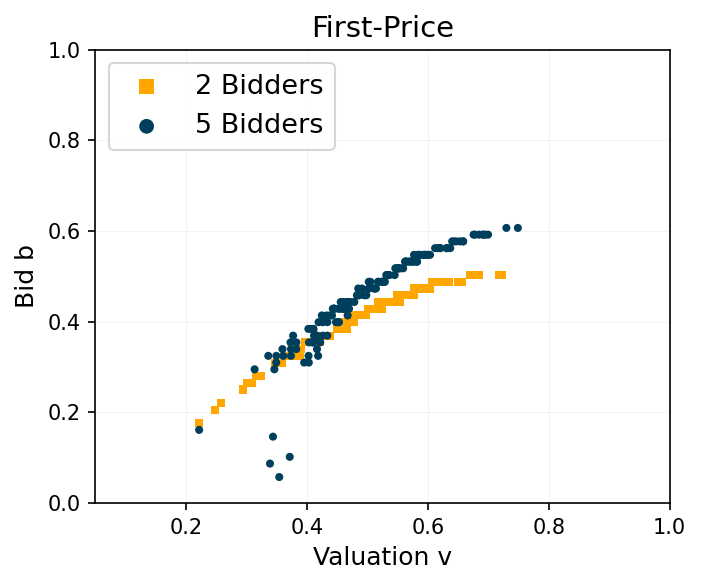

In [5]:
setting = "single_item"
util_type = 'QL'
learner = "soma_eucl_gaussian_QL"



fig, ax = set_axis((0.05,1), (0,1), f'First-Price', param)
ax.set_aspect(0.75)

for n_bidder in [2, 5]:
    exp = f"QL_FP_{n_bidder}_gaussian"

    mechanism, strategies, _ =  get_setting(setting, exp, learner, run=0)
    obs, bids = get_bids(mechanism, strategies, '1', number_o)

    # plot strategy & BNE
    ax.scatter(obs, bids, facecolors=colors[n_bidder], edgecolors='none', marker=marker[n_bidder], s=markersize, zorder=2, alpha=1)

# legend
ax.scatter([], [], facecolors=colors[2], edgecolors='none', marker=marker[2],label="2 Bidders", s=50, zorder=2, alpha=1)
ax.scatter([], [], facecolors=colors[5], edgecolors='none', marker=marker[5],label="5 Bidders", s=50, zorder=2, alpha=1)
ax.legend(fontsize=param["fontsize_legend"], loc=2)

if save:
    fig.savefig(f'plots/ql_fp_gaussian.pdf', bbox_inches='tight')

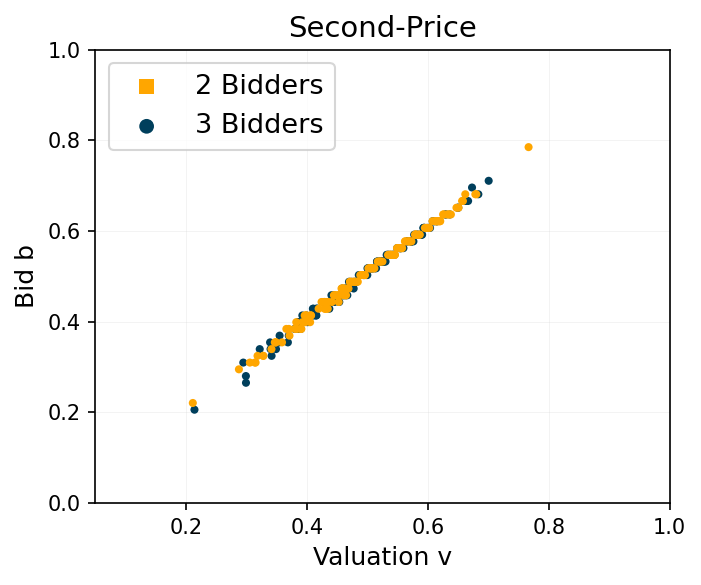

In [6]:
setting = "single_item"
util_type = 'QL'
learner = "soma_eucl_gaussian_QL"



fig, ax = set_axis((0.05,1), (0,1), f'Second-Price', param)
ax.set_aspect(0.75)

for n_bidder in [3, 2]:
    exp = f"QL_SP_{n_bidder}_gaussian"

    mechanism, strategies, _ =  get_setting(setting, exp, learner, run=0)
    obs, bids = get_bids(mechanism, strategies, '1', number_o)

    # plot strategy & BNE
    ax.scatter(obs, bids, facecolors=colors[n_bidder], edgecolors='none', marker=marker[util_type], s=markersize, zorder=2, alpha=1)

# legend
ax.scatter([], [], facecolors=colors[2], edgecolors='none', marker=marker[2],label="2 Bidders", s=50, zorder=2, alpha=1)
ax.scatter([], [], facecolors=colors[3], edgecolors='none', marker=marker[3],label="3 Bidders", s=50, zorder=2, alpha=1)
ax.legend(fontsize=param["fontsize_legend"], loc=2)

if save:
    fig.savefig(f'plots/ql_sp_gaussian.pdf', bbox_inches='tight')

# First-Price, Uniform, ROI vs. QL

own gradient
own gradient
own gradient
own gradient


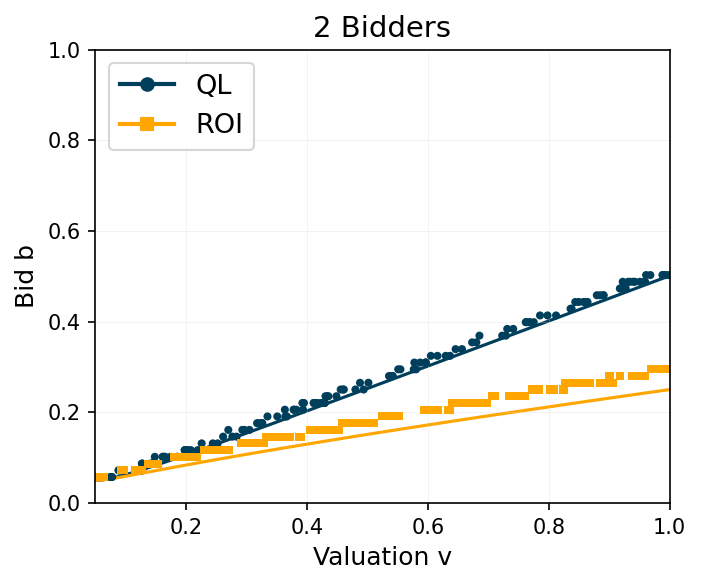

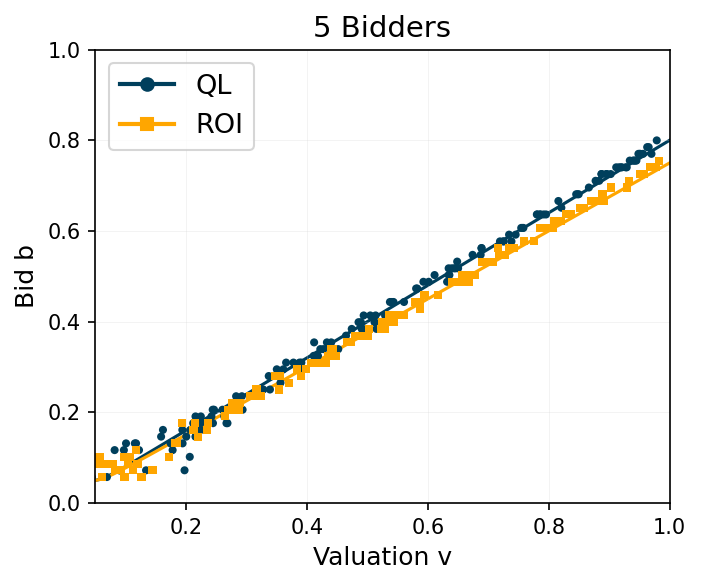

In [7]:
setting = "single_item"
experiment = lambda util_type, n_bidder: f"{util_type}_FP_{n_bidder}_uniform"
learner = lambda util_type: f"soma_eucl_uniform_{util_type}"


for n_bidder in [2,5]:

    fig, ax = set_axis((0.05,1), (0,1), f'{n_bidder} Bidders', param)
    ax.set_aspect(0.75)
    for util_type in  ["QL", "ROI"]:
        
        exp = experiment(util_type, n_bidder)
        mechanism, strategies, _ =  get_setting(setting, exp, learner(util_type), run=0)
        obs, bids = get_bids(mechanism, strategies, '1', number_o)
        x, bne = get_bne(mechanism, '1')

        # plot strategy & BNE
        ax.scatter(obs, bids, facecolors=colors[util_type], edgecolors='none', marker=marker[util_type], s=markersize, zorder=2, alpha=1)
        ax.plot(x, bne, color=colors[util_type], linestyle='-', zorder=1)

        # legend
        ax.plot([],[], label=util_type, color=colors[util_type], marker = marker[util_type], linestyle='-', linewidth=2)
        ax.legend(fontsize=param["fontsize_legend"], loc=2)

    if save:
        fig.savefig(f'plots/{n_bidder}_ql_roi.pdf', bbox_inches='tight')

# First Price, Gaussian, QL vs. ROSB

own gradient
own gradient
own gradient
own gradient


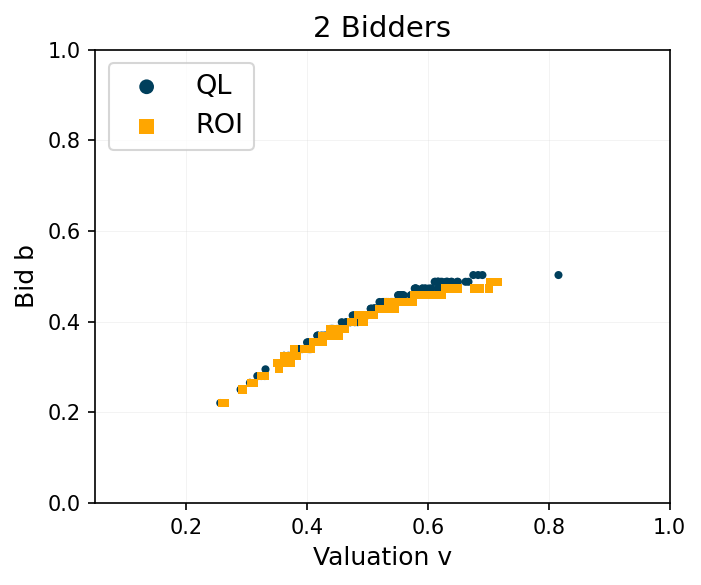

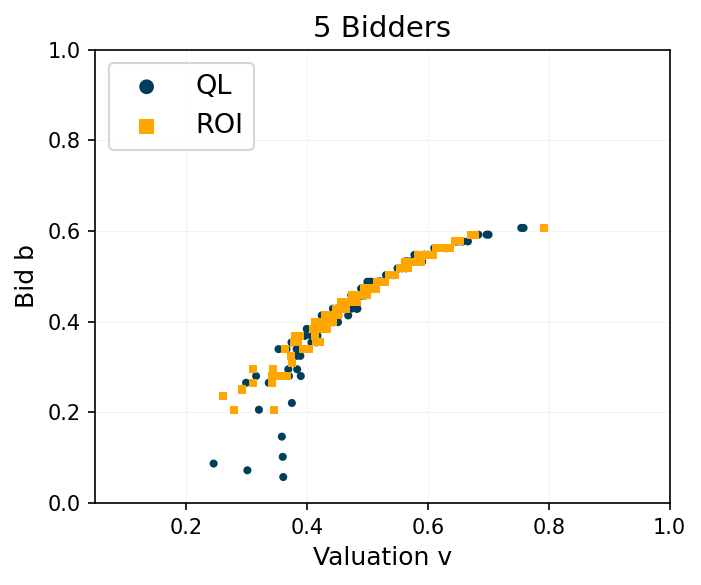

In [17]:
setting = "single_item"
experiment = lambda util_type, n_bidder: f"{util_type}_FP_{n_bidder}_gaussian"
learner = lambda util_type: f"soma_eucl_gaussian_{util_type}"


for n_bidder in [2,5]:

    fig, ax = set_axis((0.05,1), (0,1), f'{n_bidder} Bidders', param)
    ax.set_aspect(0.75)
    for util_type in  ["QL", "ROI"]:
        
        exp = experiment(util_type, n_bidder)
        mechanism, strategies, _ =  get_setting(setting, exp, learner(util_type), run=0)
        obs, bids = get_bids(mechanism, strategies, '1', number_o)
        # plot strategy & BNE
        ax.scatter(obs, bids, facecolors=colors[util_type], edgecolors='none', marker=marker[util_type], s=markersize, zorder=2, alpha=1)
        # legend
        ax.scatter([], [], facecolors=colors[util_type], edgecolors='none', marker=marker[util_type],label=util_type, s=50, zorder=2, alpha=1)
        ax.legend(fontsize=param["fontsize_legend"], loc=2)

    if save:
        fig.savefig(f'plots/{n_bidder}_ql_rosb.pdf', bbox_inches='tight')

# Analytival Solution

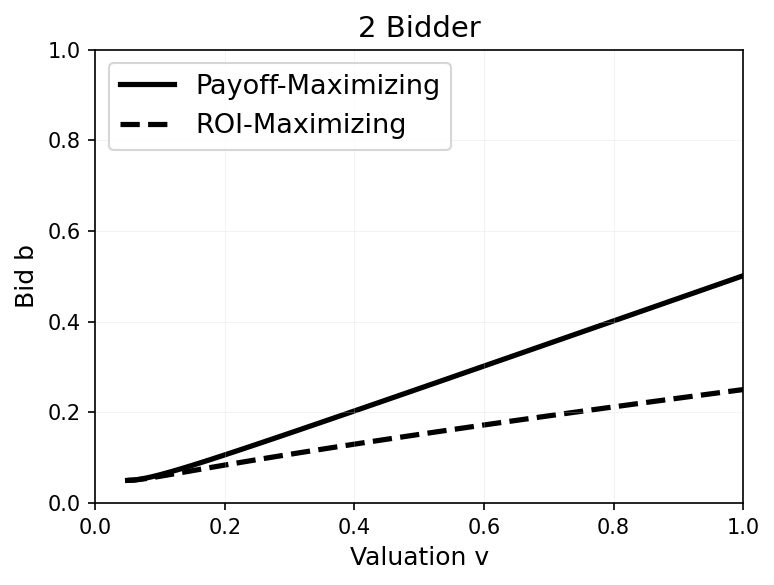

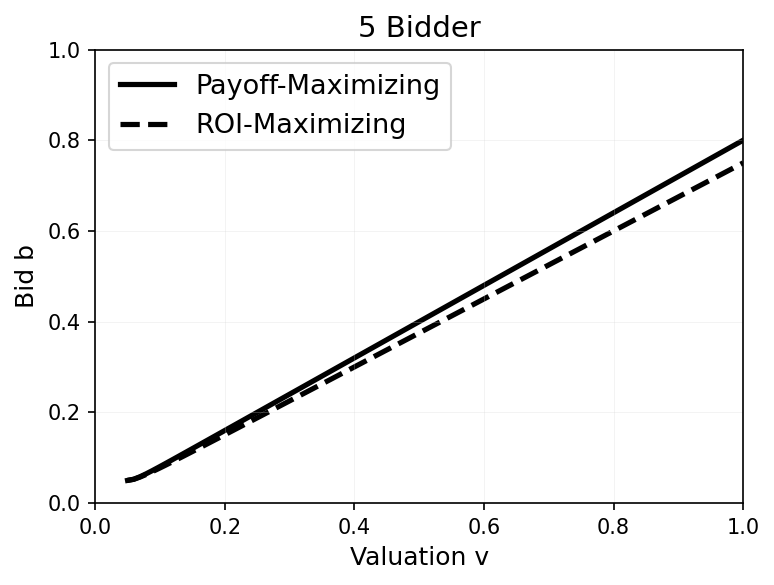

In [11]:
def bne_ql(obs, reserve_price, n_bidder):
    bne = np.zeros_like(obs)
    mask = obs >= reserve_price
    x = obs[mask]
    bne[mask] = ((n_bidder - 1) / n_bidder) * x + (
                            1 / n_bidder
                        ) * (
                            reserve_price**n_bidder
                            / x ** (n_bidder - 1)
                        )
    return bne


def bne_roi(obs, reserve_price, n_bidder):
    bne = np.zeros_like(obs)
    mask = obs >= reserve_price
    x = obs[mask]
    if n_bidder == 2:
        bne[mask] = x / (-np.log(reserve_price) + np.log(x) + 1)
    else:
        bne[mask] = (n_bidder-2) * x**(n_bidder-1)/((n_bidder-1) * x**(n_bidder-2) - reserve_price**(n_bidder-2))
    return bne


x = np.linspace(0.05,1,100)
reserve_price = 0.05



for n_bidder in [2, 5]:

    fig, ax = set_axis((0.0,1), (0,1), f'{n_bidder} Bidder', param)
    ax.set_aspect(0.7)
    ax.plot(x, bne_ql(x, reserve_price, n_bidder), color='k', linestyle='-', zorder=1, linewidth=2.5, label="Payoff-Maximizing")
    ax.plot(x, bne_roi(x, reserve_price, n_bidder), color='k', linestyle='--', zorder=1, linewidth=2.5,  label="ROI-Maximizing")

    # legend
    ax.legend(fontsize=param["fontsize_legend"], loc=2,)
    if save:
        fig.savefig(f'plots/bne_roi_ql_{n_bidder}.pdf', bbox_inches='tight')